In [1]:
from __future__ import print_function, division

import numpy as np
import time
import os
import copy
import PIL
import sys
import pickle

from tqdm import tqdm_notebook as tqdm
import seaborn as sns

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torch.optim import lr_scheduler
from torchsummary import summary

import torchvision
from torchvision import datasets, models, transforms
#from albumentations import Compose, RandomCrop, Normalize, HorizontalFlip, Resize
#from albumentations.pytorch import ToTensor


# Plots
import matplotlib.pyplot as plt
%matplotlib inline

plt.ion()   # interactive mode

In [2]:
sns.set(rc={"figure.figsize": (15, 6)})
sns.set_palette(sns.color_palette("Set2", 10))
sns.set_style("whitegrid", {'axes.grid' : False})

## Local functions

In [3]:
from dataset import *
from train import train_model
from show import *
from constants import *

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

# Constants

In [5]:
SEED = 238122

# Loading Data

## Transform data

In [6]:
dataset = FacadesDatasetH5Patches(to_file_path('images', 'hdf5'), normalized=True)

# Validation Set

In [7]:
num_crops_per_images = pickle.load(open(to_file_path('crops', 'p'), "rb" ))
crops_from_to_idx = []
from_ = 0
to = 0
for n in num_crops_per_images:
    to += n
    crops_from_to_idx.append((from_, to))
    from_ += n

In [8]:
def img_idx_to_crop_idx(indices):
    return np.array([j for i in indices for j in range(*crops_from_to_idx[i])])

In [9]:
def lenghts_split(size, perc):
    train_l =  int(0.9 * size)
    return train_l, size - train_l

In [10]:
np.random.seed(SEED)
img_indices = np.random.permutation(len(num_crops_per_images))
n_img_train, n_img_val = lenghts_split(len(num_crops_per_images), .9)
train_ind = img_idx_to_crop_idx(img_indices[:n_img_train])
train_ind = train_ind[np.random.permutation(len(train_ind))]
val_ind = img_idx_to_crop_idx(img_indices[n_img_train:])
val_ind = val_ind[np.random.permutation(len(val_ind))]

len(train_ind), len(val_ind)

(4280, 496)

In [11]:
train_dataset = Subset(dataset, train_ind)
val_dataset = Subset(dataset, val_ind)

In [12]:
batch_size = 8

In [13]:
def to_dataloader(dataset):
    return DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)

In [14]:
dataloaders = {'train': to_dataloader(train_dataset), 'val': to_dataloader(val_dataset)}

In [15]:
dataset_sizes = {phase: len(dataloaders[phase]) for phase in ['train', 'val']}

In [16]:
dataset_sizes

{'train': 535, 'val': 62}

# Statistics

In [17]:
class_weights = {v: 0 for _, v in dataset.labels.items()}
for data in tqdm(dataloaders['train']):
    lbl = data['label'].to(device)
    for v in class_weights:
        class_weights[v] += (lbl == torch.tensor(v).to(device)).sum().float() / lbl.nelement()
        
for v in class_weights:
    class_weights[v] /= len(dataloaders['train'])

In [18]:
class_weights, sum([t.item() for _, t in class_weights.items()])

({0: tensor(0.2239, device='cuda:0'),
  1: tensor(0.0291, device='cuda:0'),
  2: tensor(0.0652, device='cuda:0'),
  3: tensor(0.6121, device='cuda:0'),
  4: tensor(0.0697, device='cuda:0')},
 1.0000004060566425)

In [19]:
weights = torch.tensor([1 - w for _, w in class_weights.items()]).to(device)
weights

tensor([0.7761, 0.9709, 0.9348, 0.3879, 0.9303], device='cuda:0')

# Using AlbuNet

In [20]:
from models import AlbuNet

In [21]:
albunet = AlbuNet(
    num_classes=len(dataset.labels),
    num_filters=16,
    pretrained=True,
    is_deconv=False,
)

## Model details

In [22]:
%%capture catching_output
summary(albunet.to(device), input_size=dataset[0]['image'].shape)

In [23]:
summary_txt = catching_output.stdout
%store summary_txt > "models_summary/albunet_summary.txt"

Writing 'summary_txt' (str) to file 'models_summary/albunet_summary.txt'.


In [24]:
separator = "=" * 10
counter = 0
for l in iter(summary_txt.splitlines()):
    if separator in l:
        counter += 1
    if counter > 1:
        print(l)

Total params: 47,466,965
Trainable params: 47,466,965
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.75
Forward/backward pass size (MB): 547.75
Params size (MB): 181.07
Estimated Total Size (MB): 729.57
----------------------------------------------------------------


# Training

In [25]:
from tensorboardX import SummaryWriter
writer = SummaryWriter()

In [26]:
from torch.nn import functional as F

def dice_loss(logits, true, eps=1e-7):
    """Computes the Sørensen–Dice loss.
    Note that PyTorch optimizers minimize a loss. In this
    case, we would like to maximize the dice loss so we
    return the negated dice loss.
    Args:
        logits: a tensor of shape [B, C, H, W]. Corresponds to
            the raw output or logits of the model.
        true: a tensor of shape [B, 1, H, W].
        eps: added to the denominator for numerical stability.
    Returns:
        dice_loss: the Sørensen–Dice loss.
    """
    num_classes = logits.shape[1]
    if num_classes == 1:
        true_1_hot = torch.eye(num_classes + 1)[true.squeeze(1)]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        true_1_hot_f = true_1_hot[:, 0:1, :, :]
        true_1_hot_s = true_1_hot[:, 1:2, :, :]
        true_1_hot = torch.cat([true_1_hot_s, true_1_hot_f], dim=1)
        pos_prob = torch.sigmoid(logits)
        neg_prob = 1 - pos_prob
        probas = torch.cat([pos_prob, neg_prob], dim=1)
    else:
        true_1_hot = torch.eye(num_classes)[true.squeeze(1)]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        probas = F.softmax(logits, dim=1)
    true_1_hot = true_1_hot.type(logits.type())
    dims = (0,) + tuple(range(2, true.ndimension()))
    intersection = torch.sum(probas * true_1_hot, dims)
    cardinality = torch.sum(probas + true_1_hot, dims)
    dice_loss = (2. * intersection / (cardinality + eps)).mean()
    return (1 - dice_loss)

In [27]:
criterion = dice_loss#nn.CrossEntropyLoss(weights)
optimizer = optim.Adam(albunet.parameters())
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [ ]:
albunet = train_model(
    device=device,
    dataloaders=dataloaders,
    dataset_sizes=dataset_sizes,
    path_to_data=path_to_data,
    model_name=to_name('albunet_dice'),
    model=albunet,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=exp_lr_scheduler,
    writer=writer,
    num_epochs=20
)

Epoch 0/19
----------



train Loss: 4.1576 Acc: 0.7374



val Loss: 4.3372 Acc: 0.7248

Epoch 1/19
----------


In [ ]:
albunet.load_state_dict(torch.load("{}/models/model_albunet_weighted_cropped100_256_1024_15.torch".format(path_to_data)))

In [33]:
def iou(pred, target, n_classes = 12):
    ious = []
    pred = pred.view(-1)
    target = target.view(-1)

    # Ignore IoU for background class ("0")
    for cls in xrange(1, n_classes):  # This goes from 1:n_classes-1 -> class "0" is ignored
        pred_inds = pred == cls
        target_inds = target == cls
        intersection = (pred_inds[target_inds]).long().sum().data.cpu()[0]  # Cast to long to prevent overflows
        union = pred_inds.long().sum().data.cpu()[0] + target_inds.long().sum().data.cpu()[0] - intersection
        if union == 0:
            ious.append(float('nan'))  # If there is no ground truth, do not include in evaluation
        else:
            ious.append(float(intersection) / float(max(union, 1)))
    return np.array(ious)

# Showing Predictions

In [34]:
crop_to_img_list = [img_idx for img_idx, (from_, to) in enumerate(crops_from_to_idx) for i in range(from_, to)]
def crop_to_img(crop_idx):
    return crop_to_img_list[crop_idx]

val_images = sorted(list({crop_to_img(i) for i in val_ind}))
assert len(val_images) == n_img_val

In [35]:
def val_img_predict(idx):
    crops_to_show = img_idx_to_crop_idx(val_images[idx_to_show:idx_to_show+1])
    image_to_show = torch.stack([dataset[i]['image'] for i in crops_to_show])
    label_to_show = torch.stack([dataset[i]['label'] for i in crops_to_show])
    outputs = albunet(image_to_show.to(device))
    _, pred = torch.max(outputs, 1)
    return image_to_show, pred, label_to_show

In [36]:
pred_acc = []
for idx_to_show in range(len(val_images)):
    _, pred, label_to_show = val_img_predict(idx_to_show)
    pred_cmp = label_to_show.squeeze().to(device) == pred
    pred_acc.append(pred_cmp.sum().item() / pred_cmp.nelement())

In [37]:
padding = 10

In [38]:
idx_to_show = np.argmax(pred_acc)
n_row = 4
image_to_show, pred, label_to_show = val_img_predict(idx_to_show)
idx_to_show, pred_acc[idx_to_show]

(25, 0.7997258504231771)

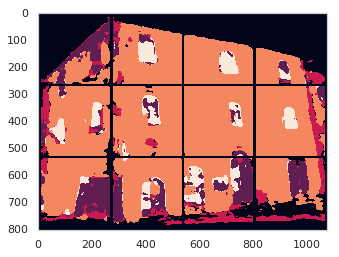

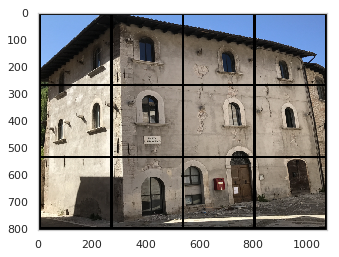

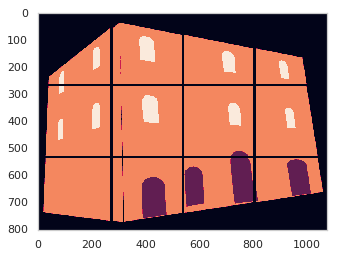

In [39]:
show_img(utils.make_grid(pred.unsqueeze(1).cpu(), nrow=n_row, padding=padding)[0].numpy())
show_img(utils.make_grid(image_to_show.cpu(), nrow=n_row, padding=padding))
show_img(utils.make_grid(label_to_show.cpu(), nrow=n_row, padding=padding)[0].numpy())

In [44]:
idx_to_show = np.argmin(pred_acc)
n_row = 4
image_to_show, pred, label_to_show = val_img_predict(idx_to_show)
idx_to_show, pred_acc[idx_to_show]

(5, 0.23770713806152344)

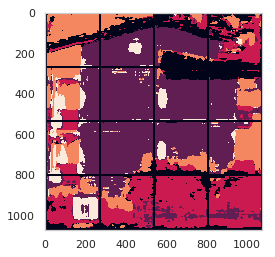

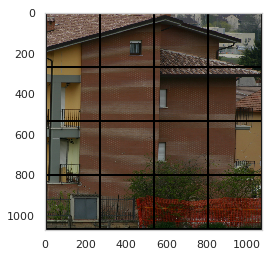

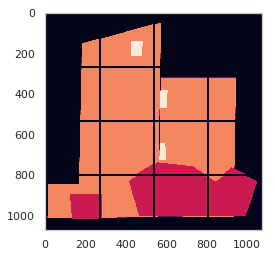

In [45]:
show_img(utils.make_grid(pred.unsqueeze(1).cpu(), nrow=n_row, padding=padding)[0].numpy())
show_img(utils.make_grid(image_to_show.cpu(), nrow=n_row, padding=padding))
show_img(utils.make_grid(label_to_show.cpu(), nrow=n_row, padding=padding)[0].numpy())

In [47]:
idx_to_show = len(pred_acc)-1
n_row = 4
image_to_show, pred, label_to_show = val_img_predict(idx_to_show)
idx_to_show, pred_acc[idx_to_show]

(41, 0.7901315689086914)

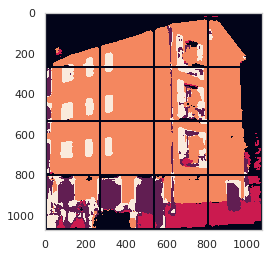

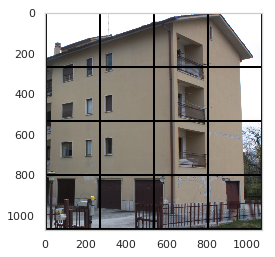

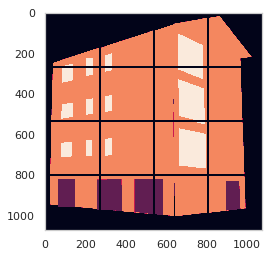

In [48]:
show_img(utils.make_grid(pred.unsqueeze(1).cpu(), nrow=n_row, padding=padding)[0].numpy())
show_img(utils.make_grid(image_to_show.cpu(), nrow=n_row, padding=padding))
show_img(utils.make_grid(label_to_show.cpu(), nrow=n_row, padding=padding)[0].numpy())